# Mocap Data Pre-processing

In [1]:
using LinearAlgebra, Random
using StatsBase, Statistics
using Distributions, MultivariateStats   # Categorical, PCA
using Quaternions    # For manipulating 3D Geometry
using MeshCat        # For web visualisation / animation
using PyPlot         # Plotting
using AxUtil, Flux   # Optimisation

# small utils libraries
using ProgressMeter, Formatting, ArgCheck
using DelimitedFiles, NPZ, BSON

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7978294144881602655\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1680823702006992374\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/5794a0bf2e6325e42dc09c7369026176a04edd3e-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-7978294144881602655\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

In [2]:
DIR_MOCAP_MTDS = "." #"""../../../mocap-mtds/";   # different cos I'm in dev folder

# Data loading and transformation utils
include(joinpath(DIR_MOCAP_MTDS, "io.jl"))

# MeshCat skeleton visualisation tools
include(joinpath(DIR_MOCAP_MTDS, "mocap_viz.jl"))

Main.mocapviz

In [3]:
cmu_loco = readdlm("../data/mocap/cmu/cmu_locomotion_lkp.txt", '\t')[:,1];
database = "../data/mocap/holden/cmu"
files_cmu = [joinpath(database, f * ".bvh") for f in cmu_loco]
files_cmu = collect(filter(x-> isfile(x) && x !== "rest.bvh", files_cmu));

database = "../data/mocap/edin-style-transfer/"
files_edin = [joinpath(database, f) for f in readdir(database)];

### Read in example data

In [191]:
proc = mocapio.process_file(files_cmu[40]);   
# 54 = PACING/STOP, 40 = BACKWARD, 115=TRIUMPHANT, 190=TWISTY, not 198 (JUMP)!

## Getting ready for training

In [4]:
# Load data from raw BVH files (1-2 mins), or load a saved version
DATA_FROM_SAVED = true

if DATA_FROM_SAVED
    Xs = BSON.load("edin_Xs.bson")[:Xs];
    Ys = BSON.load("edin_Ys.bson")[:Ys];
else
    Xs = map(files_edin) do f
        proc = mocapio.process_file(f);
        convert(Matrix{Float32}, mocapio.construct_inputs(proc))
    end;
    println("Xs finished processing...")
    Ys = map(files_edin) do f
        proc = mocapio.process_file(f);
        convert(Matrix{Float32}, 
            mocapio.construct_outputs(proc; include_ftcontact=false))
    end;
    println("Ys finished processing...")
    
    println("Do you want to save? (y/n)")
    
    for i = 1:10
        userinput = uppercase(chomp(readline()))[1]
        if userinput == 'Y'
            println("SAVING...")
            BSON.bson("edin_Xs.bson", Xs=Xs)
            BSON.bson("edin_Ys.bson", Ys=Ys)
            break
        elseif userinput == 'N'
            break
        end
    end
end;

Ysraw = Ys
Xsraw = Xs;

In [228]:
if !(@isdefined vis) 
    # Create a new visualizer instance (MeshCat.jl)
    vis = Visualizer()
    open(vis)
end
vis = mocapviz.create_animation([mocapio.reconstruct_modelled(Ysraw[7])[1:2000,:,:]], 
    "test"; vis=vis, linemesh=mocapviz.yellowmesh, camera=:back)

MeshCat Visualizer with path /meshcat

### Need to standardize inputs and outputs

`MLPreprocessing.jl` contains something like a port of `StandardScaler` from `sklearn`. However, as of 18/05/2019 it appears to be essentially broken, and given its broad generality to lots of array types, I don't want to get into this whole thing. So I'm just going to do define something myself.

In [9]:
?MyStandardScaler

search: MyStandardScaler



```
fit(MyStandardScaler, X, dims)
```

Fit a standardisation to a matrix `X` s.t. that the rows/columns have mean zero and standard deviation 1. This operation calculates the mean and standard deviation and outputs a MyStandardScalar object `s` which allows this same standardisation to be fit to any matrix using `transform(s, Y)` for some matrix `Y`. Note that the input matrix `X` is *not* transformed by this operation. Instead use the above `transform` syntax on `X`.

Note a couple of addendums:

1. Any columns/rows with constant values will result in a standard deviation of 1.0, not 0. This is to avoid NaN errors from the transformation (and it is a natural choice).
2. If only a subset of the rows/columns should be standardised, an additional argument of the indices may be given as:

    `fit(MyStandardScaler, X, operate_on, dims)`

    The subset to operate upon will be maintained through all `transform` and `invert` operations.


In [5]:
include(joinpath(DIR_MOCAP_MTDS, "util.jl"))
import .mocaputil: MyStandardScaler, scale_transform
# const scale_transform = mocaputil.transform

In [6]:
standardize_Y = fit(MyStandardScaler, reduce(vcat, Ysraw),  1)
standardize_X = fit(MyStandardScaler, reduce(vcat, Xsraw),  1)

Ys = [scale_transform(standardize_Y, y) for y in Ysraw];
Xs = [scale_transform(standardize_X, x) for x in Xsraw];

MyStandardScaler{Float32}(Float32[0.0244091, 0.0203261, 0.0165927, 0.013029, 0.00898527, 0.00460524, 0.0, -0.00476729, -0.00954481, -0.0142216  …  0.44532, -4.23134, 16.7331, 0.324697, -4.19771, 14.7953, 2.14156, -4.12908, 14.538, 2.46243], Float32[9.02737, 7.75785, 6.37511, 4.89175, 3.32386, 1.69097, 1.0, 1.6913, 3.32574, 4.89559  …  1.22956, 0.747951, 1.30283, 1.77589, 1.52968, 2.48085, 2.50114, 1.69468, 2.74355, 2.65342], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  112, 113, 114, 115, 116, 117, 118, 119, 120, 121], 1)

note that we can reconstruct the original data via the command:

    invert(standardize_Y, y)
    invert(standardize_X, x)
    
in the relevant array comprehensions.

### It is worth checking to see if it makes sense to scale everything
As shown in the input/output columns below, there is nothing that appears problematic in doing this

In [12]:
?mocapio.construct_inputs

```
construct_inputs(raw [; direction])
```

Construct the input matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to construct trajectories that extend ± 60 frames of the current position. (The additional is due to needing a bit extra to calculate velocity, plus some historical baggage.) Note also that the trajectory is centered at every frame at the current position and hence `(trajectory_x(7), trajectory_z(7)) == (0.0, 0.0)`.

The following columns are contained in the matrix:

  * (12): ± 60 frame trajectory x-cood at step 10 intervals
  * (12): ± 60 frame trajectory z-cood at step 10 intervals
  * (12): ± 60 frame trajectory angle sin(θ) to forward
  * (12): ± 60 frame trajectory angle cos(θ) to forward
  * (12): ± 60 frame trajectory magnitude of velocity
  * (61): joint positions in Lagrangian frame

The angle θ is expressed in both sine and cosine components to avoid a discontinuity when it wraps around 2π (which it sometimes does). This angle is Lagrangian in nature too: that is, θ = 0 when the skeleton is facing in exactly the same direction as it is walking (i.e. the direction of the velocity). One might prefer a Eulerian (absolute) representation instead, in which case, pass in the named argument `direction=:absolute`.

Note that there are only 61 dimensions of the joint positions as the root x,z are excluded, as they are always zero. They're excluded from the output too, which is more important: we don't want to waste strength on predicting zero.


In [10]:
?mocapio.construct_outputs

```
construct_outputs(raw [; include_ftcontact])
```

Construct the output matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to match with the input matrix which needs these boundaries in order to construct trajectories consistently. This function outputs a matrix with the following columns:

  * (3): rotational velocity, x-velocity, z-velocity
  * (61): (Lagrangian) joint positions (excl. root x/z ∵ always zero)
  * (4): [optional] feet contacts

These are the minimal requirements to reconstruct an animation of human motion on the target skeleton. The feet contacts are in {0,1} and may be challenging for some linear models, therefore they are optional (see named argument     `include_ftcontact` (Bool)).


## Last checks with visualisation

In order to visualise the *direction* of ±60 frames, we have to essentially perform FK since these directions are all relative to the forward direction at the current location. I've done this using fairly vanilla trigonometric functions below as my knowledge of quaternions and manipulating 3D graphics is not as good as it could be.

In [15]:
function angle_to_z_axis(v)
    cθ, sθ = mocapio._trigvecs(reshape(v, 1, 2), reshape([0f0 1f0], 1, 2))
    atan(-sθ[1], cθ[1])
end
rotationm(θ) = [cos(θ) sin(θ); -sin(θ) cos(θ)]

function add_angle(c1, s1, c2, s2)
    θ₁, θ₂ = atan(s1,c1), atan(s2, c2)
    return cos(θ₁ + θ₂), sin(θ₁ + θ₂)
end

add_angle (generic function with 1 method)

In [114]:
ii = 436

436

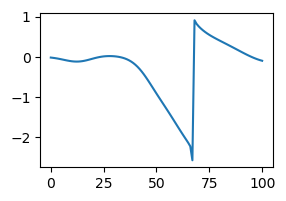

In [112]:
plot(atan.(Xsraw[4][ii-50:ii+50, 24+7], Xsraw[4][ii-50:ii+50, 36+7]))
gcf().set_size_inches(3,2)

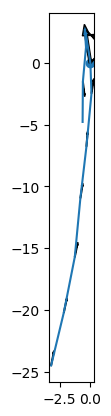

In [116]:
tmp_new = hcat(Xsraw[4][ii,1:12], Xsraw[4][ii,13:24])
plot(tmp_new[:,1], tmp_new[:,2])
scatter(0,0)
arrow(0,0, diff(tmp_new[7:8,1])[1], diff(tmp_new[7:8,2])[1], width=.2)
for j in 1:11
    dirΔ = [tmp_new[j+1,1] - tmp_new[j,1], tmp_new[j+1,2] - tmp_new[j,2]]
    dirΔ /= sqrt(sum(z->z^2, dirΔ))
    std_cθ, std_sθ = add_angle(Xsraw[4][ii,24+j], Xsraw[4][ii,36+j], 0, -1)
    cθ, sθ = add_angle(dirΔ[1], dirΔ[2], std_cθ, -std_sθ)
    arrow(tmp_new[j,1],tmp_new[j,2], cθ, sθ, width=.05)
end
gca().set_aspect("equal")
# ii += 5

In [108]:
if !(@isdefined vis) 
    # Create a new visualizer instance (MeshCat.jl)
    vis = Visualizer()
    open(vis)
end
vis = mocapviz.create_animation([mocapio.reconstruct_modelled(Ysraw[4])[300:550,:,:]], 
    "test"; vis=vis, linemesh=mocapviz.yellowmesh, camera=:back)

MeshCat Visualizer with path /meshcat

## Everything looks good

**Note** the input traces look slightly odd during sharp/stopping "about" turns as frequently the trajectory turns in the opposite direction to the body. Since the turning circle is so tight, it is probably not well defined which way the trajectory turns, and anchoring to the *actual position* of the root joint is a good a way as any. The point is that while it may look a little odd, the processing is doing the right thing, and the information will be available to the model.

## Look at principal components

In [218]:
?mocapio.construct_inputs

```
construct_inputs(raw [; direction])
```

Construct the input matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to construct trajectories that extend ± 60 frames of the current position. (The additional is due to needing a bit extra to calculate velocity, plus some historical baggage.) Note also that the trajectory is centered at every frame at the current position and hence `(trajectory_x(7), trajectory_z(7)) == (0.0, 0.0)`.

The following columns are contained in the matrix:

  * (12): ± 60 frame trajectory x-cood at step 10 intervals
  * (12): ± 60 frame trajectory z-cood at step 10 intervals
  * (12): ± 60 frame trajectory angle sin(θ) to forward
  * (12): ± 60 frame trajectory angle cos(θ) to forward
  * (12): ± 60 frame trajectory magnitude of velocity
  * (61): joint positions in Lagrangian frame

The angle θ is expressed in both sine and cosine components to avoid a discontinuity when it wraps around 2π (which it sometimes does). This angle is Lagrangian in nature too: that is, θ = 0 when the skeleton is facing in exactly the same direction as it is walking (i.e. the direction of the velocity). One might prefer a Eulerian (absolute) representation instead, in which case, pass in the named argument `direction=:absolute`.

Note that there are only 61 dimensions of the joint positions as the root x,z are excluded, as they are always zero. They're excluded from the output too, which is more important: we don't want to waste strength on predicting zero.


In [11]:
allE = reduce(vcat, Ys);
allE = convert(Matrix{Float32}, allE);

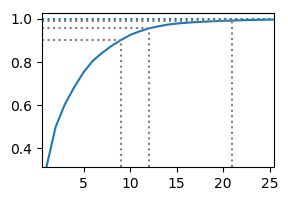

In [20]:
zsc(x, dims) = (x .- mean(x, dims=dims)) ./ std(x, dims=dims)

pc_all = fit(PCA, zsc(allE[:,4:63]', 1), pratio=0.999)

varexpl = cumsum(principalvars(pc_all))/tvar(pc_all)
bd=findfirst.([varexpl .> x for x in [0.9,0.95,0.99]])
plot(1:length(varexpl), varexpl)
gca().axhline(1, linestyle=":")
for b in bd
    plot([b,b], [varexpl[1], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
    plot([.5, b], [varexpl[b], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
end
gca().set_xlim(0.5,25.5); gca().set_ylim(varexpl[1],1.025);
gcf().set_size_inches(3,2)

#### Note
This is different (worse, i.e. need more PCs) than the graph I showed to Chris. This is because I was in the Eulerian frame, where direction(s) of movement probably captured most of PCs. Removing these high variance directions, common to all joints makes it much harder.